In [ ]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# Check the uploaded file
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Saving 3.csv to 3.csv
Uploaded file: 3.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [ ]:
# Load the data
file_path = "3.csv"  # Replace with your file path
data = pd.read_csv(file_path)

In [ ]:
# Handling missing values (fill with forward fill method)
data['Verified (m)'] = data['Verified (m)'].fillna(method='ffill')

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort by Date (if not sorted)
data = data.sort_values(by='Date')

<ipython-input-57-9651950795ca>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Verified (m)'] = data['Verified (m)'].fillna(method='ffill')


In [ ]:
# Normalize the 'Verified (m)' column
scaler = MinMaxScaler(feature_range=(0, 1))
data['Verified (m)'] = scaler.fit_transform(data[['Verified (m)']])

In [ ]:
# Prepare sequences for LSTM
def create_sequences(data, sequence_length):
    x = []
    y = []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i])
        y.append(data[i])
    return np.array(x), np.array(y)

sequence_length = 30  # Lookback window of 30 days
values = data['Verified (m)'].values
x, y = create_sequences(values, sequence_length)

In [ ]:
# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0078 - val_loss: 0.0042
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

In [ ]:
# Make predictions
train_predictions = model.predict(x_train)
test_predictions = model.predict(x_test)

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [ ]:
# Reverse scaling
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform([y_train])
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform([y_test])

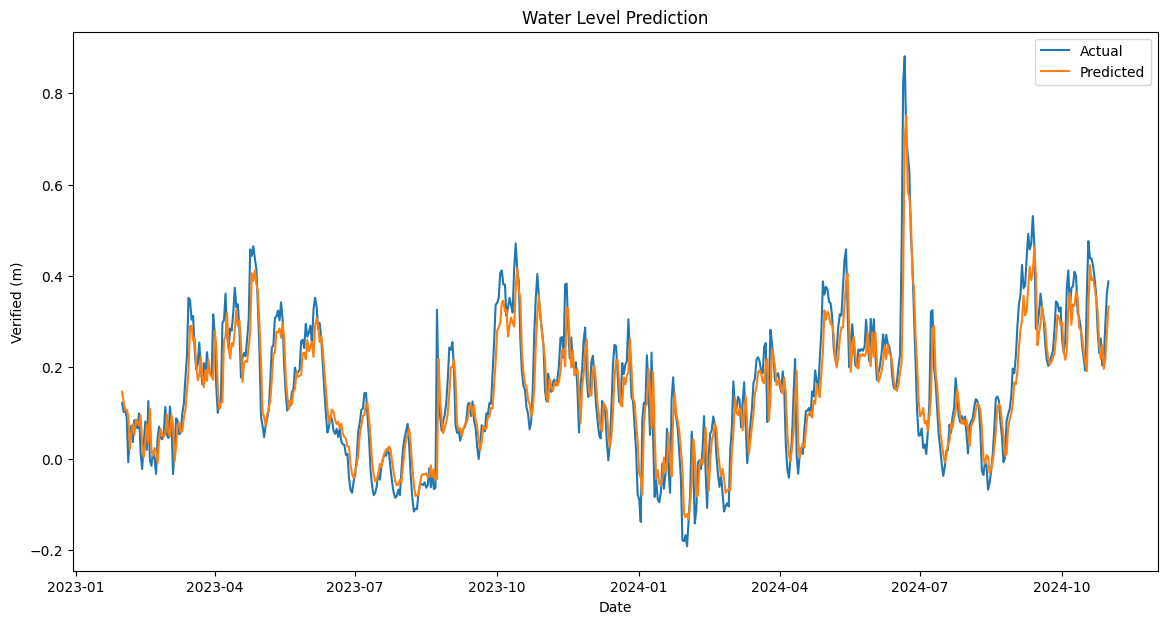

In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(data['Date'][-len(y_test[0]):], y_test[0], label="Actual")
plt.plot(data['Date'][-len(y_test[0]):], test_predictions, label="Predicted")
plt.title("Water Level Prediction")
plt.xlabel("Date")
plt.ylabel("Verified (m)")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [ ]:
# Calculate evaluation metrics for the test set
mae = mean_absolute_error(y_test[0], test_predictions)
mse = mean_squared_error(y_test[0], test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test[0], test_predictions)

In [ ]:
# Print the metrics
print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0451
Mean Squared Error (MSE): 0.0038
Root Mean Squared Error (RMSE): 0.0615
R-squared (R²): 0.8347


In [ ]:
#using XGBoost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Load the data
file_path = "CO-OPS_8775237_WL.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Handling missing values (fill with forward fill method)
data['Verified (m)'] = data['Verified (m)'].fillna(method='ffill')

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort by Date (if not sorted)
data = data.sort_values(by='Date')

# Normalize the 'Verified (m)' column
scaler = MinMaxScaler(feature_range=(0, 1))
data['Verified (m)'] = scaler.fit_transform(data[['Verified (m)']])

FileNotFoundError: [Errno 2] No such file or directory: 'CO-OPS_8775237_WL.csv'

In [ ]:
# Feature engineering: Create lag features for XGBoost
def create_lag_features(df, target_col, lags):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

# Add lag features
lags = 30  # Number of lag days
data = create_lag_features(data, 'Verified (m)', lags)


In [ ]:
# Drop rows with NaN values created by lagging
data = data.dropna()


In [ ]:
# Separate features and target variable
X = data[[f'lag_{i}' for i in range(1, lags + 1)]]
y = data['Verified (m)']

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Train an XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

In [ ]:
# Make predictions
train_predictions = xgb_model.predict(X_train)
test_predictions = xgb_model.predict(X_test)

In [ ]:
# Reverse scaling for the predictions
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])
train_predictions = scaler.inverse_transform([train_predictions])
test_predictions = scaler.inverse_transform([test_predictions])

In [ ]:
# Evaluation Metrics
mae = mean_absolute_error(y_test[0], test_predictions[0])
mse = mean_squared_error(y_test[0], test_predictions[0])
rmse = np.sqrt(mse)
r2 = r2_score(y_test[0], test_predictions[0])

print("Model Evaluation Metrics (XGBoost):")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

In [ ]:
# Plot predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['Date'][-len(y_test[0]):], y_test[0], label="Actual")
plt.plot(data['Date'][-len(y_test[0]):], test_predictions[0], label="Predicted")
plt.title("Water Level Prediction (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Verified (m)")
plt.legend()
plt.show()

In [ ]:
#GPR
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Load the data
file_path = "CO-OPS_8775237_WL.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Handling missing values (fill with forward fill method)
data['Verified (m)'] = data['Verified (m)'].fillna(method='ffill')

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort by Date (if not sorted)
data = data.sort_values(by='Date')

In [ ]:
# Normalize the 'Verified (m)' column
scaler = MinMaxScaler(feature_range=(0, 1))
data['Verified (m)'] = scaler.fit_transform(data[['Verified (m)']])

In [ ]:
# Feature engineering: Create lag features
def create_lag_features(df, target_col, lags):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

# Add lag features
lags = 30  # Number of lag days
data = create_lag_features(data, 'Verified (m)', lags)

# Drop rows with NaN values created by lagging
data = data.dropna()

# Separate features and target variable
X = data[[f'lag_{i}' for i in range(1, lags + 1)]]
y = data['Verified (m)']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
# Define the kernel for GPR
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

In [ ]:
# Train Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr.fit(X_train, y_train)


In [ ]:
# Make predictions
train_predictions, train_std = gpr.predict(X_train, return_std=True)
test_predictions, test_std = gpr.predict(X_test, return_std=True)

In [ ]:
# Reverse scaling for predictions
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])
train_predictions = scaler.inverse_transform([train_predictions])
test_predictions = scaler.inverse_transform([test_predictions])

In [ ]:
# Evaluation Metrics
mae = mean_absolute_error(y_test[0], test_predictions[0])
mse = mean_squared_error(y_test[0], test_predictions[0])
rmse = np.sqrt(mse)
r2 = r2_score(y_test[0], test_predictions[0])
print("Model Evaluation Metrics (Gaussian Process Regression):")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(data['Date'][-len(y_test[0]):], y_test[0], label="Actual")
plt.plot(data['Date'][-len(y_test[0]):], test_predictions[0], label="Predicted")
plt.fill_between(data['Date'][-len(y_test[0]):],
                 test_predictions[0] - test_std,
                 test_predictions[0] + test_std,
                 color='gray', alpha=0.2, label="Uncertainty")
plt.title("Water Level Prediction (Gaussian Process Regression)")
plt.xlabel("Date")
plt.ylabel("Verified (m)")
plt.legend()
plt.show()